# Dataset selection pour notebook 04b

## Imports

In [38]:
import os
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import logging
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess


## Variables

In [ ]:
# Today's date for output naming
todays_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

GEOPARQUET_CLASSIFICATION_PATH = "data/notebook_02/parquet/02_gdf_toiture_7_classification.parquet"
SPLIT_GEOTIFF_1024_PARQUET = "data/notebook_04/geotiff/tile_1024_split/combined_metadata.parquet"
SAMPLES_PER_CAT = 8

GRAPHICS_PATH = "data/notebook_06/graphics"
GPKG_SELECTION_DATASET = "data/notebook_06/parquet/06a_02_dataset.gpkg"
GPKG_CAD_COMMUNE = "data/SITG/CAD_COMMUNE_2024-11-03.gpkg"

CONVERT_GEOTIFF_TO_PNG = True

# Output directory for PNG files
PNG_OUTPUT_PATH = f"data/notebook_06/dataset_{todays_date}"
os.makedirs(PNG_OUTPUT_PATH, exist_ok=True)

In [41]:
assert(os.path.exists(GEOPARQUET_CLASSIFICATION_PATH))
assert(os.path.exists(GRAPHICS_PATH))
assert(os.path.exists(PNG_OUTPUT_PATH))

## Charger données

In [42]:
gdf_toiture_7_classification = gpd.read_parquet(GEOPARQUET_CLASSIFICATION_PATH)

In [43]:
assert(gdf_toiture_7_classification["egid"].isna().sum() == 0)
gdf_toiture_7_classification["egid"].duplicated().sum() == 0

False

In [44]:
len(gdf_toiture_7_classification["egid"].unique())

77993

## Nettoyage et enrichir les données

### geotiff parquet

In [45]:
df_split_geotiff = pd.read_parquet(SPLIT_GEOTIFF_1024_PARQUET)

In [46]:
df_split_geotiff.dtypes

geotiff_path               object
tile_path                  object
tile_id                    object
tile_row                    int64
tile_col                    int64
tile_bounds                object
buffered_bounds            object
tile_size                   int64
buffer_size                 int64
tile_pixel_size            object
objectid                    int64
egid                      float64
altitude_min              float64
altitude_max              float64
date_leve          datetime64[ns]
SHAPE__Length             float64
SHAPE__Area               float64
globalid                   object
geometry                   object
dtype: object

In [47]:
gdf_toiture_7_classification.dtypes

objectid                               int64
egid                                 float64
altitude_min                         float64
altitude_max                         float64
date_leve                     datetime64[ms]
SHAPE__Length                        float64
SHAPE__Area                          float64
globalid                              object
geometry                            geometry
sia_cat                               object
shape_area_sup_2m2                      bool
has_fully_contained_holes               bool
fully_contained_hole_count             int64
total_hole_area                      float64
valid_geometry                          bool
hole_area_ratio                      float64
sp_contains                             bool
sp_within                               bool
sp_overlaps                             bool
sp_element_count                       int64
sp_relation_type                      object
has_sp_elements                         bool
classifica

### sia_cat

In [ ]:
# Copy split geotiff dataframe
df_split_geotiff_sia_cat = df_split_geotiff.copy()

# Find common columns, excluding geometry
common_columns = set(df_split_geotiff_sia_cat.columns) & set(gdf_toiture_7_classification.columns)
common_columns = list(common_columns - {"geometry"})

# Merge classification with split geotiff data
df_split_geotiff_sia_cat = pd.merge(
    gdf_toiture_7_classification,
    df_split_geotiff_sia_cat,
    on=common_columns,
    how="left"
)

In [49]:
df_split_geotiff_sia_cat.head(5)

,objectid,egid,altitude_min,altitude_max,date_leve,SHAPE__Length,SHAPE__Area,globalid,geometry_x,sia_cat,...,tile_path,tile_id,tile_row,tile_col,tile_bounds,buffered_bounds,tile_size,buffer_size,tile_pixel_size,geometry_y
0,204857,295010023.0,462.00,465.46,2005-08-01 02:00:00,34.891045,69.277396,96076844-3ED9-4647-A7C3-F96D6CE16B71,"MULTIPOLYGON (((2491819.683 1110772.52, 249181...",II habitat individuel,...,data/notebook_04/geotiff/tile_1024_split/24911...,4_15_47740e,4,15,"(2491768.0, 1110744.0, 2491819.2, 1110795.2)","(2491761.6, 1110737.6, 2491825.6, 1110801.6)",1024,128,"[1024, 1024]",None
1,204857,295010023.0,462.00,465.46,2005-08-01 02:00:00,34.891045,69.277396,96076844-3ED9-4647-A7C3-F96D6CE16B71,"MULTIPOLYGON (((2491819.683 1110772.52, 249181...",II habitat individuel,...,data/notebook_04/geotiff/tile_1024_split/24911...,4_16_0758c1,4,16,"(2491819.2, 1110744.0, 2491870.4, 1110795.2)","(2491812.8, 1110737.6, 2491876.8, 1110801.6)",1024,128,"[1024, 1024]",None
2,204873,295010485.0,461.31,465.51,2005-08-01 02:00:00,42.022790,86.952040,987C8B52-793B-4BB1-85C5-D091BFA398D7,"MULTIPOLYGON (((2491841.218 1110782.921, 24918...",II habitat individuel,...,data/notebook_04/geotiff/tile_1024_split/24911...,4_16_0758c1,4,16,"(2491819.2, 1110744.0, 2491870.4, 1110795.2)","(2491812.8, 1110737.6, 2491876.8, 1110801.6)",1024,128,"[1024, 1024]",None
3,7630,295510865.0,461.41,462.00,2016-03-01 01:00:00,9.284492,4.487861,E3C6375D-ECCC-4A0A-95EA-2CA279603F4A,"MULTIPOLYGON (((2491828.479 1110777.597, 24918...",X dépôts,...,data/notebook_04/geotiff/tile_1024_split/24911...,4_15_47740e,4,15,"(2491768.0, 1110744.0, 2491819.2, 1110795.2)","(2491761.6, 1110737.6, 2491825.6, 1110801.6)",1024,128,"[1024, 1024]",None
4,7630,295510865.0,461.41,462.00,2016-03-01 01:00:00,9.284492,4.487861,E3C6375D-ECCC-4A0A-95EA-2CA279603F4A,"MULTIPOLYGON (((2491828.479 1110777.597, 24918...",X dépôts,...,data/notebook_04/geotiff/tile_1024_split/24911...,4_16_0758c1,4,16,"(2491819.2, 1110744.0, 2491870.4, 1110795.2)","(2491812.8, 1110737.6, 2491876.8, 1110801.6)",1024,128,"[1024, 1024]",None


In [ ]:
# Ensure all roofs are associated with a tile
assert(len(df_split_geotiff_sia_cat[df_split_geotiff_sia_cat["tile_path"].isnull()][["egid", "SHAPE__Area", "globalid", "sia_cat", "tile_id"]].sort_values(by=["SHAPE__Area"], ascending=False)) == 0)

In [ ]:
# Save enriched dataframe to Parquet
df_split_geotiff_sia_cat.to_parquet("data/notebook_06/06a_02_split_geotiff_sia_cat.parquet")

## Selection dataset

In [ ]:
# Copy the enriched dataframe
df_selection = df_split_geotiff_sia_cat.copy()

# Shuffle rows for randomness
df_selection = df_selection.sample(frac=1, random_state=42).reset_index(drop=True)

display(df_selection.head(5))
display(df_selection.columns)

,objectid,egid,altitude_min,altitude_max,date_leve,SHAPE__Length,SHAPE__Area,globalid,geometry_x,sia_cat,...,tile_path,tile_id,tile_row,tile_col,tile_bounds,buffered_bounds,tile_size,buffer_size,tile_pixel_size,geometry_y
0,329095,295111395.0,423.41,425.30,2011-04-01 02:00:00,38.491628,64.397208,816720D1-FDBE-4648-8908-DF60F554F64F,"MULTIPOLYGON (((2498475.395 1118496.957, 24984...",I habitat collectif,...,data/notebook_04/geotiff/tile_1024_split/24981...,10_8_ead0c0,10,8,"(2498409.6, 1118436.8, 2498460.8, 1118488.0)","(2498403.2, 1118430.4, 2498467.2, 1118494.4)",1024,128,"[1024, 1024]",None
1,154123,1022853.0,435.83,439.52,2005-08-01 02:00:00,47.026828,59.728847,21C3B7FA-1F9D-45CC-8393-2CB471F8F906,"MULTIPOLYGON (((2496065.557 1112800.588, 24960...",I habitat collectif,...,data/notebook_04/geotiff/tile_1024_split/24961...,3_0_d5a933,3,0,"(2496000.0, 1112795.2, 2496051.2, 1112846.4)","(2496000.0, 1112788.8, 2496064.0, 1112852.8)",1024,128,"[1024, 1024]",None
2,109361,295077084.0,426.63,426.63,2005-08-01 02:00:00,173.526290,514.696408,BCCD7819-A726-4167-A358-5D8981CFC265,"MULTIPOLYGON (((2499427.094 1118410.19, 249942...",IV écoles,...,data/notebook_04/geotiff/tile_1024_split/24991...,10_8_2931b8,10,8,"(2499409.6, 1118436.8, 2499460.8, 1118488.0)","(2499403.2, 1118430.4, 2499467.2, 1118494.4)",1024,128,"[1024, 1024]",None
3,259350,1006447.0,457.45,460.51,2011-04-01 02:00:00,42.988671,89.620253,C9B5410B-6542-49CF-A14D-C79BC0A9F6F7,"MULTIPOLYGON (((2506394.974 1120190.762, 25063...",I habitat collectif,...,data/notebook_04/geotiff/tile_1024_split/25061...,15_7_91308e,15,7,"(2506358.4, 1120180.8, 2506409.6, 1120232.0)","(2506352.0, 1120174.4, 2506416.0, 1120238.4)",1024,128,"[1024, 1024]",None
4,68745,1007363.0,430.60,434.06,2005-08-01 02:00:00,25.741669,36.341416,14E45189-E1E9-453D-9716-87CEE76C0BD9,"MULTIPOLYGON (((2505004.439 1122197.452, 25050...",II habitat individuel,...,data/notebook_04/geotiff/tile_1024_split/25051...,15_0_72e349,15,0,"(2505000.0, 1122180.8, 2505051.2, 1122232.0)","(2505000.0, 1122174.4, 2505064.0, 1122238.4)",1024,128,"[1024, 1024]",None


Index(['objectid', 'egid', 'altitude_min', 'altitude_max', 'date_leve',
       'SHAPE__Length', 'SHAPE__Area', 'globalid', 'geometry_x', 'sia_cat',
       'shape_area_sup_2m2', 'has_fully_contained_holes',
       'fully_contained_hole_count', 'total_hole_area', 'valid_geometry',
       'hole_area_ratio', 'sp_contains', 'sp_within', 'sp_overlaps',
       'sp_element_count', 'sp_relation_type', 'has_sp_elements',
       'classification', 'classification_simplified', 'classification_comment',
       'geotiff_path', 'tile_path', 'tile_id', 'tile_row', 'tile_col',
       'tile_bounds', 'buffered_bounds', 'tile_size', 'buffer_size',
       'tile_pixel_size', 'geometry_y'],
      dtype='object')

### Analyse

In [53]:
# Egid par tile
df_selection.groupby("tile_id")["egid"].nunique().reset_index().sort_values(by=["egid"], ascending=False)

,tile_id,egid
25816,3_15_da3148,43
37828,9_5_3cd725,37
10403,14_14_2080d2,36
33284,7_16_83146f,36
32473,6_8_a5cc03,36
...,...,...
7937,13_0_378db8,1
7938,13_0_39b019,1
14495,16_15_4d6376,1
14493,16_15_4a32ba,1


In [54]:
# sum of SHAPE__Area by tile_id
df_selection.groupby("tile_id")["SHAPE__Area"].sum().reset_index().sort_values(by=["SHAPE__Area"], ascending=False)

,tile_id,SHAPE__Area
9038,13_1_6b2851,61222.184315
7115,12_2_03d597,60885.826710
8014,13_0_f9aef5,60414.838361
9160,13_2_a6c12e,40134.753247
7252,12_3_539544,39384.404392
...,...,...
36177,8_8_a49b39,4.922119
37355,9_19_92475d,4.774622
5668,11_7_d59c6d,4.360349
2434,10_14_cf4b4a,4.293359


In [55]:
# cat SIA par tile
df_selection.groupby("tile_id")["sia_cat"].nunique().reset_index().sort_values(by=["sia_cat"], ascending=False)

,tile_id,sia_cat
31881,6_1_edd541,8
36182,8_8_b22828,8
6172,12_11_c9ca7e,8
32886,7_12_1c919b,7
31927,6_2_6f39ec,7
...,...,...
15762,16_9_0b80c8,1
7241,12_3_402854,1
26606,3_5_0c43c0,1
15758,16_9_065e95,1


In [ ]:
# Number of unique egid per tile
df_selection["egid_per_tile"] = df_selection.groupby("tile_id")["egid"].transform("nunique")

# Number of unique sia_cat per tile
df_selection["sia_cat_per_tile"] = df_selection.groupby("tile_id")["sia_cat"].transform("nunique")

# Total SHAPE__Area per tile
df_selection["SHAPE__Area_sum_per_tile"] = df_selection.groupby("tile_id")["SHAPE__Area"].transform("sum")

### Sélection SIA_cat + area_bins

In [ ]:
from collections import Counter

# Aggregate roof data by tile_id
tile_groups = df_selection.groupby('tile_id').agg({
    'globalid': list,
    'geometry_x': list,
    'sia_cat': list,
    'altitude_min': 'mean',
    'altitude_max': 'mean',
    'date_leve': 'first',
    'tile_path': 'first',
    'tile_bounds': 'first',
    "SHAPE__Area": 'sum',
}).reset_index()

# Assign dominant SIA class per tile
tile_groups['dominant_class'] = tile_groups['sia_cat'].apply(
    lambda x: Counter(x).most_common(1)[0][0]
)

# Bin tiles by total area
area_bins = [0, 200, 500, 1000, 2000, 5000, np.inf]
tile_groups['area_bin'] = pd.cut(
    tile_groups['SHAPE__Area'],
    bins=area_bins,
    labels=[
        '0-200', '200-500', '500-1000',
        '1000-2000', '2000-5000', '5000+'
    ]
)

print("Manual Bins:")
print(tile_groups['area_bin'].value_counts().sort_index())


Manual Bins:
area_bin
0-200         5838
200-500       6834
500-1000     10062
1000-2000     8685
2000-5000     5345
5000+         1530
Name: count, dtype: int64


In [ ]:
# Sample up to SAMPLES_PER_CAT tiles per dominant_class and area_bin
def sample_tiles(group, n_samples):
    if len(group) > n_samples:
        return group.sample(n=n_samples, random_state=42)
    return group

sampled_df = tile_groups.groupby(['dominant_class', 'area_bin']).apply(
    sample_tiles, n_samples=SAMPLES_PER_CAT
).reset_index(drop=True)

# Convert tile_bounds to Polygon geometry
def convert_bounds_to_polygon(bounds):
    if isinstance(bounds, str):
        bounds = tuple(map(float, bounds.strip("()").split(",")))
    if len(bounds) == 4:
        minx, miny, maxx, maxy = bounds
        return Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy)])
    raise ValueError(f"Invalid bounds format: {bounds}")

sampled_df['geometry'] = sampled_df['tile_bounds'].apply(convert_bounds_to_polygon)

# Create GeoDataFrame and save to file
sampled_gdf = gpd.GeoDataFrame(sampled_df, geometry='geometry', crs='EPSG:2056')
sampled_gdf.to_file(GPKG_SELECTION_DATASET, driver="GPKG", layer="sampled_tiles")


/tmp/ipykernel_2850195/2421708164.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_df = tile_groups.groupby(['dominant_class', 'area_bin']).apply(
/tmp/ipykernel_2850195/2421708164.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = tile_groups.groupby(['dominant_class', 'area_bin']).apply(


## Visualisation
### Graphiques

/tmp/ipykernel_2850195/3117911210.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(
/tmp/ipykernel_2850195/3117911210.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')


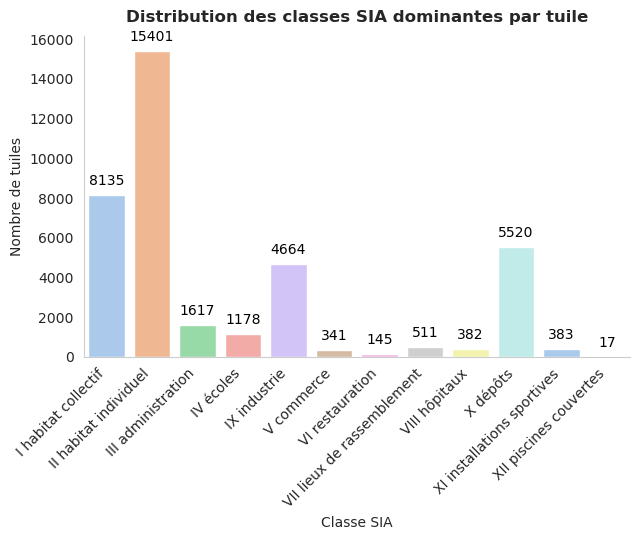

In [ ]:
# Count dominant SIA classes per tile
class_counts = tile_groups['dominant_class'].value_counts().reset_index()
class_counts.columns = ['Classe SIA', 'Nombre de tiles']

sns.set_style("whitegrid")

plt.figure(figsize=(6.5, 5.5))
plot = sns.barplot(
    x='Classe SIA', 
    y='Nombre de tiles', 
    data=class_counts.sort_values(by='Classe SIA'),
    palette='pastel',
)

# Improve label readability
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

total_tiles = class_counts['Nombre de tiles'].sum()

plt.title("Distribution des classes SIA dominantes par tuile", fontsize=12, pad=10, fontweight='bold')
plt.xlabel("Classe SIA", fontsize=10)
plt.ylabel("Nombre de tuiles", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Annotate bar values
for p in plot.patches:
    plot.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color='black',
        xytext=(0, 5), 
        textcoords='offset points'
    )

sns.despine()
plt.tight_layout()
plt.grid(False)

plt.savefig(os.path.join(GRAPHICS_PATH, "06a_01_dominant_class_distribution.png"), dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_2850195/3126387440.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(


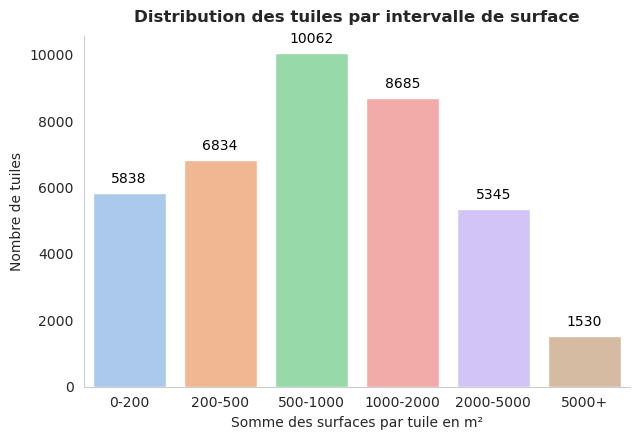

In [ ]:
plt.close()

# Count tiles per area bin
area_counts = tile_groups['area_bin'].value_counts().reset_index()
area_counts.columns = ['Area Bin', 'Nombre de tiles']
area_counts = area_counts.sort_values(by='Area Bin')

sns.set_style("whitegrid")

plt.figure(figsize=(6.5, 4.5))
plot = sns.barplot(
    x='Area Bin', 
    y='Nombre de tiles', 
    data=area_counts,
    palette='pastel',
)

total_tiles = area_counts['Nombre de tiles'].sum()

plt.title("Distribution des tuiles par intervalle de surface", fontsize=12, fontweight='bold', pad=10)
plt.xlabel("Somme des surfaces par tuile en m²", fontsize=10)
plt.ylabel("Nombre de tuiles", fontsize=10)
plt.tick_params(axis='both', labelsize=10)
plot.xaxis.get_offset_text().set_fontsize(10)
plot.yaxis.get_offset_text().set_fontsize(10)

# Annotate bar values
for p in plot.patches:
    plot.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color='black',
        xytext=(0, 5), 
        textcoords='offset points'
    )

sns.despine()
plt.tight_layout()
plt.grid(False)

plt.savefig(os.path.join(GRAPHICS_PATH, "06a_02_area_bin_distribution.png"), dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_2850195/856036570.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stacked_data = sampled_df.groupby(['dominant_class', 'area_bin']).size().unstack().fillna(0)


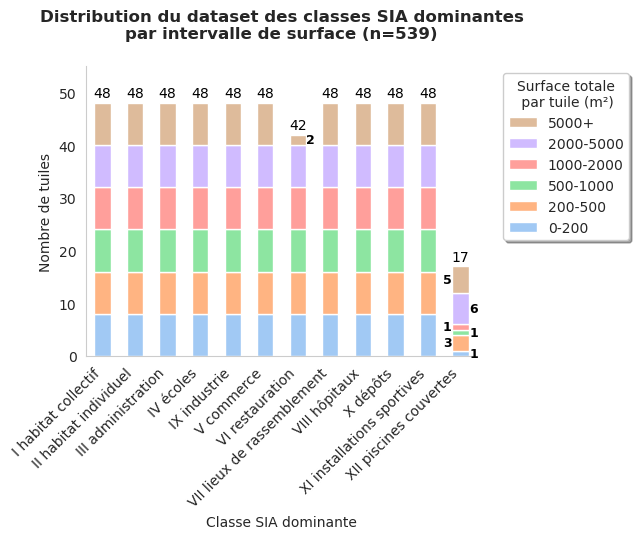

In [ ]:
plt.close()

sns.set_style("whitegrid")

# Prepare data for stacked bar plot
stacked_data = sampled_df.groupby(['dominant_class', 'area_bin']).size().unstack().fillna(0)
area_order = ['0-200', '200-500', '500-1000', '1000-2000', '2000-5000', '5000+']
stacked_data = stacked_data.reindex(columns=area_order)

colors = sns.color_palette("pastel", len(stacked_data.columns))

plt.figure(figsize=(6.5, 5.5))

stacked_data.plot(
    kind='bar', 
    stacked=True, 
    color=colors,
    ax=plt.gca()
)

plt.xticks(rotation=45, ha='right')

total_samples = stacked_data.sum().sum()
plt.title(f"Distribution du dataset des classes SIA dominantes\npar intervalle de surface (n={int(total_samples)})", 
          fontsize=12, pad=20, fontweight='bold')
plt.xlabel("Classe SIA dominante", fontsize=10)
plt.ylabel("Nombre de tuiles", fontsize=10)
plt.tick_params(axis='both', labelsize=10)
plot.xaxis.get_offset_text().set_fontsize(10)
plot.yaxis.get_offset_text().set_fontsize(10)

plt.legend(
    title="Surface totale\n par tuile (m²)", 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left',
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=10,
    title_fontsize=10,
    reverse=True
)

plt.ylim(0, 55)
sns.despine()
plt.grid(False)

# Annotate total per bar
for i, total in enumerate(stacked_data.sum(axis=1)):
    plt.text(i, total + 0.5, f'{int(total)}', 
             ha='center', va='bottom', fontsize=10, color='black')

# Annotate segments with low sample count
for i, (index, row) in enumerate(stacked_data.iterrows()):
    bottom = 0
    annotation_count = 0
    for j, (area_bin, count) in enumerate(row.items()):
        if 0 < count < 8:
            segment_middle = bottom + count/2
            offset = 0.4
            x_offset = i + offset if annotation_count % 2 == 0 else i - offset
            plt.text(x_offset, segment_middle, f'{int(count)}', 
                     ha='center', va='center', fontsize=9, 
                     color='black', fontweight='demibold')
            annotation_count += 1
        bottom += count

plt.tight_layout()
plt.savefig(os.path.join(GRAPHICS_PATH, "06a_03_stacked.png"), dpi=300, bbox_inches='tight')
plt.show()


### Vue en plan

/tmp/ipykernel_2850195/965381943.py:43: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  ax = gdf.plot(


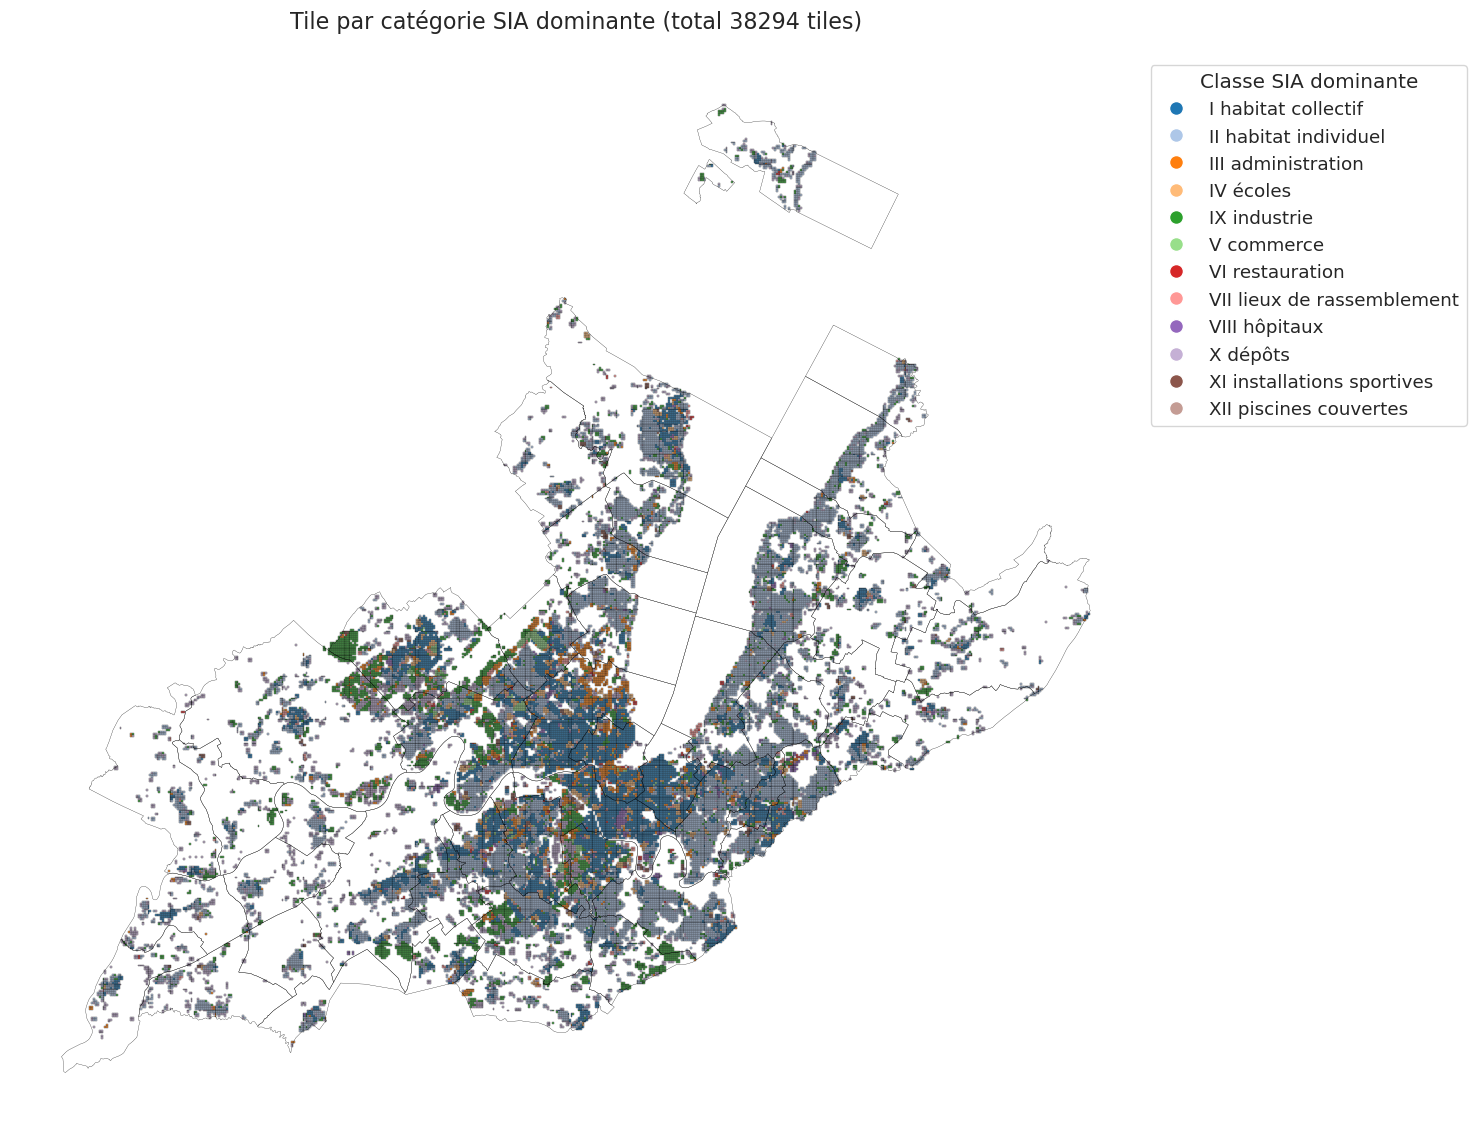

In [ ]:
def bounds_to_polygon(bounds_str):
    """Convert '(minx, miny, maxx, maxy)' string to Polygon."""
    try:
        coords = [float(x) for x in bounds_str.strip("()").split(", ")]
        return Polygon([
            (coords[0], coords[1]),
            (coords[2], coords[1]),
            (coords[2], coords[3]),
            (coords[0], coords[3])
        ])
    except ValueError:
        logging.error(f"Error converting bounds to polygon: {bounds_str}")
        return None

sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)

# Add geometry column
tile_groups['geometry'] = tile_groups['tile_bounds'].apply(bounds_to_polygon)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(tile_groups, geometry='geometry', crs="EPSG:2056")

unique_classes = sorted(gdf['dominant_class'].unique())
palette = sns.color_palette('tab20', n_colors=len(unique_classes))
color_dict = dict(zip(unique_classes, palette))

# Plot tiles by dominant class
ax = gdf.plot(
    figsize=(15, 15),
    column='dominant_class',
    legend=True,
    legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    edgecolor='black',
    linewidth=0.3,
    alpha=0.7,
    color=gdf['dominant_class'].map(color_dict)
)

# Overlay commune boundaries
cad_commune = gpd.read_file(GPKG_CAD_COMMUNE, layer="CAD_COMMUNE")
cad_commune = cad_commune.to_crs("EPSG:2056")
cad_commune.plot(ax=ax, color="none", edgecolor="black", linewidth=0.2)

# Custom legend
ax.legend(
    handles=[plt.Line2D([0], [0], marker='o', color='w', label=cls, 
                        markerfacecolor=color_dict[cls], markersize=10) for cls in unique_classes],
    title="Classe SIA dominante",
    loc='upper left',
    bbox_to_anchor=(1, 1)
)

ax.set_title(f"Tile par catégorie SIA dominante (total {len(tile_groups)} tiles)", fontsize=16, pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(GRAPHICS_PATH, "06a_04_map_tiles_group.png"), dpi=300, bbox_inches='tight')
plt.close()


/tmp/ipykernel_2850195/549281393.py:28: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf.plot(


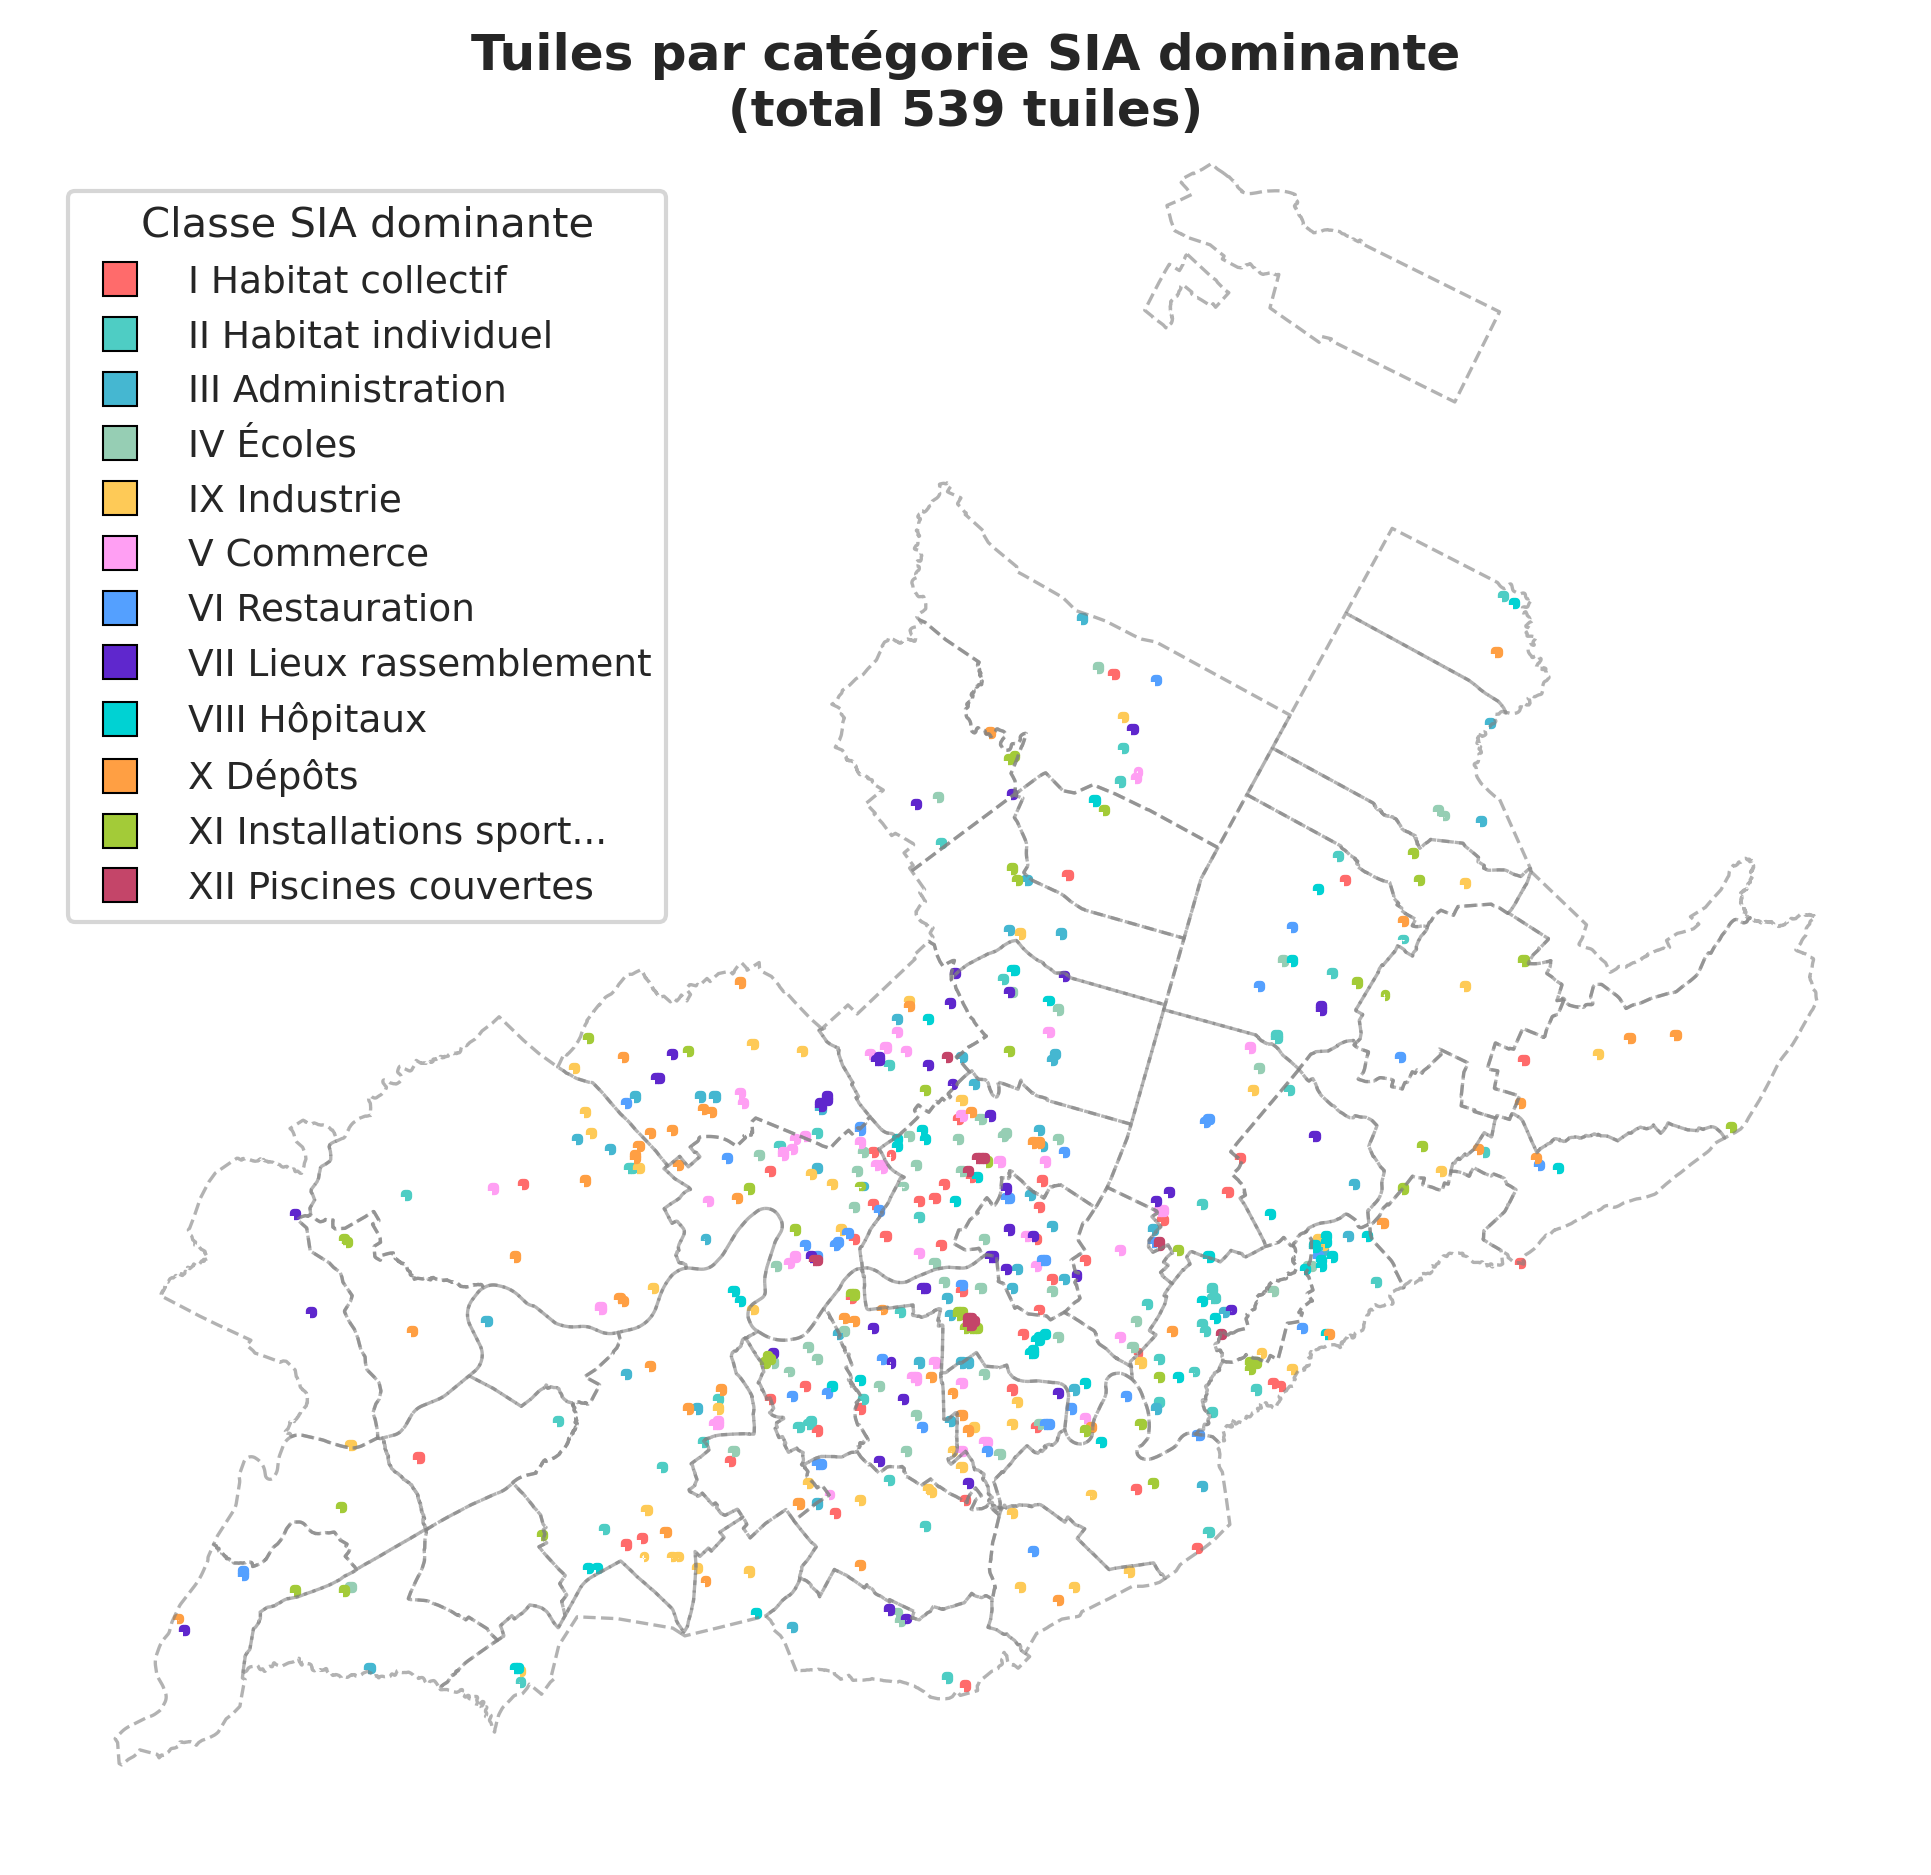

In [ ]:
plt.close()

# Geometry from bounds
sampled_df['geometry'] = sampled_df['tile_bounds'].apply(bounds_to_polygon)

# GeoDataFrame
gdf = gpd.GeoDataFrame(sampled_df, geometry='geometry', crs="EPSG:2056")

unique_classes = sorted(gdf['dominant_class'].unique())

sns.set_style("whitegrid")

vibrant_colors = [
    '#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', 
    '#FF9FF3', '#54A0FF', '#5F27CD', '#00D2D3', '#FF9F43',
    '#A3CB38', '#C44569'
]
color_dict = dict(zip(unique_classes, vibrant_colors[:len(unique_classes)]))

fig, ax = plt.subplots(figsize=(6.5, 6.5), dpi=300)

# Plot tiles by dominant class
gdf.plot(
    column='dominant_class',
    ax=ax,
    edgecolor=gdf['dominant_class'].map(color_dict),
    linewidth=2,
    alpha=1,
    color=gdf['dominant_class'].map(color_dict)
)

# Plot commune boundaries
cad_commune = gpd.read_file(GPKG_CAD_COMMUNE, layer="CAD_COMMUNE")
cad_commune = cad_commune.to_crs("EPSG:2056")
cad_commune.plot(ax=ax, color="none", edgecolor="grey", linewidth=0.8, alpha=0.6, ls='--')

# Shortened labels for legend
class_labels = {
    'I habitat collectif': 'I Habitat collectif',
    'II habitat individuel': 'II Habitat individuel', 
    'III administration': 'III Administration',
    'IV écoles': 'IV Écoles',
    'IX industrie': 'IX Industrie',
    'V commerce': 'V Commerce',
    'VI restauration': 'VI Restauration',
    'VII lieux de rassemblement': 'VII Lieux rassemblement',
    'VIII hôpitaux': 'VIII Hôpitaux',
    'X dépôts': 'X Dépôts',
    'XI installations sportives': 'XI Installations sportives',
    'XII piscines couvertes': 'XII Piscines couvertes'
}

legend_elements = []
for cls in unique_classes:
    label = class_labels.get(cls, cls)
    if len(label) > 25:
        label = label[:22] + "..."
    legend_elements.append(
        plt.Line2D([0], [0], marker='s', color='w', label=label,
                   markerfacecolor=color_dict[cls], markersize=8, 
                   markeredgecolor='black', markeredgewidth=0.5)
    )

# Legend
legend = ax.legend(
    handles=legend_elements,
    title="Classe SIA dominante",
    loc='upper right',
    bbox_to_anchor=(0.35, 0.95),
    fontsize=9,
    title_fontsize=10,
)

ax.set_title(f"Tuiles par catégorie SIA dominante\n(total {len(sampled_df)} tuiles)", fontsize=12, pad=-10, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.subplots_adjust(left=0.02, right=0.98, top=0.95, bottom=0.02)

plt.savefig(os.path.join(GRAPHICS_PATH, "06a_05_map_sampled_df.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
import folium
import pyproj

# Coordinate systems
swiss_cs = pyproj.CRS("EPSG:2056")
wgs84_cs = pyproj.CRS("EPSG:4326")
transformer = pyproj.Transformer.from_crs(swiss_cs, wgs84_cs, always_xy=True)

def swiss_to_wgs84(east, north):
    """Convert Swiss coordinates to WGS84 (lat, lon)."""
    lon, lat = transformer.transform(east, north)
    return [lat, lon]

all_sw_points = []
all_ne_points = []

for tile_id in sampled_df['tile_id'].tolist():
    tile_row = sampled_df[sampled_df['tile_id'] == tile_id]
    if len(tile_row) == 0:
        continue
    bounds = tile_row['tile_bounds'].values[0]
    if isinstance(bounds, str):
        bounds_clean = bounds.strip('()').replace(' ', '')
        bounds_list = bounds_clean.split(',')
        bounds = tuple(float(x) for x in bounds_list if x)
    if len(bounds) >= 4:
        minx, miny, maxx, maxy = bounds[:4]
        sw = swiss_to_wgs84(minx, miny)
        ne = swiss_to_wgs84(maxx, maxy)
        all_sw_points.append(sw)
        all_ne_points.append(ne)

if all_sw_points and all_ne_points:
    avg_lat = np.mean([pt[0] for pt in all_sw_points + all_ne_points])
    avg_lon = np.mean([pt[1] for pt in all_sw_points + all_ne_points])
    print(f"Center of all tiles (lat, lon): {avg_lat}, {avg_lon}")
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=14)
else:
    print("No valid coordinates found")
    m = folium.Map(location=[46.2044, 6.1432], zoom_start=12)

tiles_added = 0
for tile_id in sampled_df['tile_id'].tolist():
    tile_row = sampled_df[sampled_df['tile_id'] == tile_id]
    if len(tile_row) == 0:
        continue
    bounds = tile_row['tile_bounds'].values[0]
    if isinstance(bounds, str):
        bounds_clean = bounds.strip('()').replace(' ', '')
        bounds_list = bounds_clean.split(',')
        bounds = tuple(float(x) for x in bounds_list if x)
    if len(bounds) >= 4:
        minx, miny, maxx, maxy = bounds[:4]
        sw = swiss_to_wgs84(minx, miny)
        ne = swiss_to_wgs84(maxx, maxy)
        nw = swiss_to_wgs84(minx, maxy)
        se = swiss_to_wgs84(maxx, miny)
        folium.Polygon(
            locations=[sw, nw, ne, se],
            color='blue',
            weight=1,
            fill=True,
            fill_opacity=0.4,
            tooltip=f"Tile ID: {tile_id}"
        ).add_to(m)
        tiles_added += 1

print(f"Added {tiles_added} tiles to the map")
m


Center of all tiles (lat, lon): 46.20696834904376, 6.132684753238462
Added 539 tiles to the map


## Tif to PNG for roboflow

In [29]:
sampled_df

,tile_id,globalid,geometry_x,sia_cat,altitude_min,altitude_max,date_leve,tile_path,tile_bounds,SHAPE__Area,dominant_class,area_bin,geometry
0,10_12_8d26a8,"[72BC0BCB-C609-49C3-9EBB-DAEE02CBEDDD, FFE74AC...",[MULTIPOLYGON (((2503608.772986766 1119445.827...,"[I habitat collectif, I habitat collectif, I h...",489.953333,490.244359,2009-06-01 02:00:00,data/notebook_04/geotiff/tile_1024_split/25031...,"(2503614.4, 1119436.8, 2503665.6, 1119488.0)",199.548631,I habitat collectif,0-200,"POLYGON ((2503614.4 1119436.8, 2503665.6 11194..."
1,0_6_9201e5,"[F24DC253-B282-4519-A142-07A8FFB9BE07, 4B14DFD...",[MULTIPOLYGON (((2505336.6089233235 1123970.43...,"[I habitat collectif, IX industrie]",400.530000,400.530000,2019-06-08 02:00:00,data/notebook_04/geotiff/tile_1024_split/25051...,"(2505307.2, 1123948.8, 2505358.4, 1124000.0)",179.861729,I habitat collectif,0-200,"POLYGON ((2505307.2 1123948.8, 2505358.4 11239..."
2,18_4_b35ef3,"[D2047155-7D5C-4CC1-844B-3B672C640CD4, CF36522...",[MULTIPOLYGON (((2508196.947274536 1121027.500...,"[I habitat collectif, I habitat collectif, I h...",449.933333,451.150000,2005-08-01 02:00:00,data/notebook_04/geotiff/tile_1024_split/25081...,"(2508204.8, 1121027.2, 2508256.0, 1121078.4)",53.230689,I habitat collectif,0-200,"POLYGON ((2508204.8 1121027.2, 2508256 1121027..."
3,1_3_14c592,"[79D87CAC-FD37-4E23-8E22-A2C21CFF9CB8, B67ACD2...",[MULTIPOLYGON (((2499157.8717038035 1113954.70...,"[I habitat collectif, II habitat individuel, I...",428.777500,429.172500,2016-03-01 01:00:00,data/notebook_04/geotiff/tile_1024_split/24991...,"(2499153.6, 1113897.6, 2499204.8, 1113948.8)",123.196509,I habitat collectif,0-200,"POLYGON ((2499153.6 1113897.6, 2499204.8 11138..."
4,15_17_5212bb,[8C0ECDB2-A52C-4264-B8F0-B6A0CF4265EC],[MULTIPOLYGON (((2497846.2721914724 1118232.80...,[I habitat collectif],441.730000,441.730000,2005-08-01 02:00:00,data/notebook_04/geotiff/tile_1024_split/24971...,"(2497870.4, 1118180.8, 2497921.6, 1118232.0)",149.408228,I habitat collectif,0-200,"POLYGON ((2497870.4 1118180.8, 2497921.6 11181..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,3_4_b3ad65,"[B1980713-C6E1-4A86-82B6-4A87CE51F273, 1D82797...",[MULTIPOLYGON (((2499209.2930179797 1116797.81...,"[XI installations sportives, XII piscines couv...",383.553333,385.350000,2005-08-01 02:00:00,data/notebook_04/geotiff/tile_1024_split/24991...,"(2499204.8, 1116795.2, 2499256.0, 1116846.4)",13789.697277,XII piscines couvertes,5000+,"POLYGON ((2499204.8 1116795.2, 2499256 1116795..."
535,3_5_677ebf,"[99C7DEF7-DFAB-432B-A603-32FA55DBD4E6, BC4351B...",[MULTIPOLYGON (((2499310.4791426584 1116795.54...,"[XII piscines couvertes, XII piscines couverte...",383.035455,384.018182,2019-06-08 02:00:00,data/notebook_04/geotiff/tile_1024_split/24991...,"(2499256.0, 1116795.2, 2499307.2, 1116846.4)",6335.337284,XII piscines couvertes,5000+,"POLYGON ((2499256 1116795.2, 2499307.2 1116795..."
536,3_6_9b5376,"[9A7B7EE9-9A27-441F-B7BB-0D0603DAA632, 1BFD855...",[POLYGON ((2499221.7868457213 1116825.41106994...,"[XII piscines couvertes, XII piscines couverte...",380.806667,381.910000,2019-06-08 02:00:00,data/notebook_04/geotiff/tile_1024_split/24991...,"(2499307.2, 1116795.2, 2499358.4, 1116846.4)",7865.847542,XII piscines couvertes,5000+,"POLYGON ((2499307.2 1116795.2, 2499358.4 11167..."
537,4_4_6684a3,"[5B38246D-A4DA-46AA-9CE9-209EAE8A87E2, AD38E59...",[MULTIPOLYGON (((2499222.5404473953 1116794.66...,"[IX industrie, IX industrie, XII piscines couv...",384.831250,386.653750,2005-08-01 02:00:00,data/notebook_04/geotiff/tile_1024_split/24991...,"(2499204.8, 1116744.0, 2499256.0, 1116795.2)",12738.381889,XII piscines couvertes,5000+,"POLYGON ((2499204.8 1116744, 2499256 1116744, ..."


In [ ]:
def convert_tiff_to_png(sample_df, output_dir):
    """Convert GeoTIFF files in sample_df['tile_path'] to PNG format for roboflow."""
    # Create output directory with timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    output_dir = Path(output_dir) / f"PNG_dataset_roboflow_{timestamp}"
    output_dir.mkdir(parents=True, exist_ok=True)
    logging.info(f"Output directory created: {output_dir}")

    # Get unique TIFF file paths
    tiff_files = sample_df["tile_path"].dropna().unique().tolist()
    tiff_files = [Path(file) if not isinstance(file, Path) else file for file in tiff_files]
    logging.info(f"Found {len(tiff_files)} unique TIFF files to process")

    for tiff_file in tqdm(tiff_files, desc="Converting to PNG"):
        if not Path(tiff_file).exists():
            logging.warning(f"Source file not found: {tiff_file}")
            continue

        png_file = output_dir / f"{Path(tiff_file).stem}.png"
        if not png_file.exists():
            try:
                subprocess.run(
                    [
                        "gdal_translate",
                        "-of", "PNG",
                        "-co", "ZLEVEL=9",
                        "-co", "PREDICTOR=2",
                        "-ot", "Byte",
                        "-r", "nearest",
                        "-co", "COMPRESS=PNG",
                        str(tiff_file),
                        str(png_file),
                    ],
                    check=True,
                    capture_output=True,
                    text=True,
                )
                logging.info(f"Converted {Path(tiff_file).name}")
            except subprocess.CalledProcessError as e:
                logging.error(f"Error converting {tiff_file}: {e.stderr}")
            except Exception as e:
                logging.error(f"Unexpected error processing {tiff_file}: {str(e)}")
        else:
            logging.info(f"Skipping {Path(tiff_file).name} (already exists)")

    logging.info(f"Conversion complete. Files saved to {output_dir}")
    sample_df.to_csv(output_dir / "sampled_tiles.csv", index=False)
    return output_dir


In [ ]:
# Convert GeoTIFF tiles to PNG if enabled
if CONVERT_GEOTIFF_TO_PNG:
    convert_tiff_to_png(
        sampled_df,
        PNG_OUTPUT_PATH,
    )

Converting to PNG:   0%|          | 0/539 [00:00<?, ?it/s]

KeyboardInterrupt: 